# Case Study Prompt : 

As you know, we just started offering promotions to our riders in the form of discounts. Our goal was to encourage more trips from the savings we provided, but we’re seeing the same levels of engagement. Rider signups have seen a slight lift overall, but it’s consistent with last year at this time.

I was hoping your team could dig into how users are engaging with our promotions and whether we’re seeing any net
benefit from them. If we could evaluate the financial effectiveness of these promotions, the analysis might inform a more cost-conscious approach than what we currently have in place.

This is the overall design of the discount campaign:
● 10% off surged trips
● Users requesting in Chelsea Court
● Monday through Friday
● Users had to opt-in to the promotion via email


# Preliminary Data Exploration

First, we load some important libraries for our analysis, as well as the data from the different excel sheets into dataframes.

In [1]:
## Import the general libraries for this analysis

import warnings
warnings.simplefilter('ignore')
from IPython.display import clear_output
from IPython.display import display
from operator import itemgetter

## Date time and Analytical Libraries

import math
import datetime as dt
from datetime import datetime
from datetime import timedelta 
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency
from scipy.stats import chi2
from scipy.stats import ttest_ind

## Visualisation Libraries

import matplotlib.pyplot as plt

clear_output()

In [2]:
# get the sheet names of the excel file
pd.ExcelFile('data_set_170705.xlsx').sheet_names

['Metric Descriptions',
 'driver_trips',
 'rider_trips',
 'driver_data',
 'rider_data',
 'city_metrics']

In [3]:
driver_trips_df = pd.read_excel('data_set_170705.xlsx', sheetname='driver_trips')
rider_trips_df = pd.read_excel('data_set_170705.xlsx', sheetname='rider_trips')
driver_data_df = pd.read_excel('data_set_170705.xlsx', sheetname='driver_data')
rider_data_df = pd.read_excel('data_set_170705.xlsx', sheetname='rider_data')
city_metrics_df = pd.read_excel('data_set_170705.xlsx', sheetname='city_metrics')

In [4]:
driver_trips_df.info()
rider_trips_df.info()
print(rider_trips_df['trip_status'].unique())

# check for duplicate id columns
ids = driver_trips_df['trip_id']
display(driver_trips_df[ids.isin(ids[ids.duplicated()])].sort('trip_id'))

id2 = rider_trips_df['trip_id']
display(rider_trips_df[id2.isin(id2[id2.duplicated()])].sort('trip_id'))
rider_trips_df[~rider_trips_df['trip_id'].isin(ids)]['trip_status'].unique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59854 entries, 0 to 59853
Data columns (total 9 columns):
trip_id                   59854 non-null object
driver_id                 59854 non-null object
trip_status               59854 non-null object
actual_time_to_arrival    53583 non-null float64
request_time              59854 non-null datetime64[ns]
surge_multiplier          59854 non-null float64
driver payout             59854 non-null float64
start_geo                 59854 non-null object
end_geo                   59854 non-null object
dtypes: datetime64[ns](1), float64(3), object(5)
memory usage: 4.1+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 10 columns):
trip_id                      60000 non-null object
rider_id                     60000 non-null object
trip_status                  60000 non-null object
estimated_time_to_arrival    57499 non-null float64
request_time                 60000 non-null datetime64[ns]
surge

,trip_id,driver_id,trip_status,actual_time_to_arrival,request_time,surge_multiplier,driver payout,start_geo,end_geo
14974,94a1-82d8,4b99-c52e,completed,5.116667,2012-04-26 21:37:00,1.0,5.2032,Chelsea Court,Chelsea Court
33759,94a1-82d8,4e79-a40f,unfulfilled,NaN,2012-04-14 20:02:00,1.0,0.0000,Chelsea Court,Chelsea Court


,trip_id,rider_id,trip_status,estimated_time_to_arrival,request_time,surge_multiplier,trip_price_pre_discount,rider_payment,start_geo,end_geo
15011,94a1-82d8,ffc6-7d21,completed,4.616667,2012-04-26 21:37:00,1.0,6.504,6.504,Chelsea Court,Chelsea Court
33831,94a1-82d8,fe7b-ea19,unfulfilled,NaN,2012-04-14 20:02:00,1.0,0.000,0.000,Chelsea Court,Chelsea Court


array(['rider_canceled'], dtype=object)

The preliminary data exploration shows that there are null values in the estimated_time_to_arrival column in the riders_trips dataframe, and in the actual_time_to_arrival column in the drivers_trips_df. Understandably, failed and unfulfilled rides should have null values in these columns. For the others, a regression analysis can be used to estimate the actual time when estimated time is present. However, there are still about 2200 entries for completed trips where there are nulls in both columns. 

But, the nulls make up only 4.2% of the ETA data, and since most of our analysis is performed on an aggregated level, reliable insights can be drawn, and the difference between the error from nulls would be similar to the error we would make from imputation of values. 

The trip ids should be unique primary keys, but there is a duplicate entry in both the riders and drivers trips tables. These are easily imputed with a temporary id code. Notes should be made to engineering / the ETL pipeline team to ensure proper tagging of trip ids in the data collection process.

There are slightly more trips (60000) in the riders trips table than the drivers trips table (59854). However, checking these shows that the riders cancelled these trips, probably before a driver could be dispatched. As such, we can go ahead and use the riders trips table as the basis for our main trips table for analysis, and join some information from the drivers table.

In [5]:
## replace index where trip id matches to 0001-temp
driver_trips_df.loc[33759, 'trip_id'] = '0001-temp'
rider_trips_df.loc[33831, 'trip_id'] = '0001-temp'
 
## join both driver and rider tables
trips_df = rider_trips_df.merge(
    driver_trips_df, left_on = 'trip_id', right_on = 'trip_id', how = 'left', suffixes = ('','_driver'))[[
        'trip_id', 'rider_id', 'driver_id', 'trip_status', 'estimated_time_to_arrival', 'actual_time_to_arrival',
        'request_time','surge_multiplier','trip_price_pre_discount','rider_payment','driver payout', 'start_geo',
        'end_geo']]

## fill null joins for drivers with not applicable in the driver id col

trips_df['driver_id'].fillna('not applicable', inplace = True)
trips_df['driver payout'].fillna(0, inplace = True)


## extract day of week, date, and time of day from request time stamps

trips_df['day'] = trips_df['request_time'].dt.weekday_name
trips_df['date'] = trips_df['request_time'].dt.date
trips_df['time'] = trips_df['request_time'].dt.hour

## create a column for Uber's revenue from trips
trips_df['uber_revenue'] = trips_df['rider_payment'] - trips_df['driver payout']

trips_df.head()

,trip_id,rider_id,driver_id,trip_status,estimated_time_to_arrival,actual_time_to_arrival,request_time,surge_multiplier,trip_price_pre_discount,rider_payment,driver payout,start_geo,end_geo,day,date,time,uber_revenue
0,b3cb-b9bf,5ba9-cd29,4649-2f0a,completed,4.483333,3.516667,2012-04-09 06:12:00,1.0,5.296,5.296,4.2368,Allen Abby,Chelsea Court,Monday,2012-04-09,6,1.0592
1,8569-0fbf,b8ed-f739,4003-e2e7,completed,4.683333,2.633333,2012-05-06 05:44:00,2.0,10.304,10.304,8.2432,Blair Bend,Chelsea Court,Sunday,2012-05-06,5,2.0608
2,86f2-e4cc,a12d-275f,44af-7b74,completed,1.983333,1.333333,2012-04-25 11:28:00,1.0,7.744,7.744,6.1952,Chelsea Court,Blair Bend,Wednesday,2012-04-25,11,1.5488
3,aef6-924e,14af-2a91,4909-aa90,completed,2.750000,1.700000,2012-04-27 21:34:00,1.0,10.232,10.232,8.1856,Chelsea Court,Daisy Drive,Friday,2012-04-27,21,2.0464
4,921a-11d3,a0b5-fbfc,4e79-a40f,completed,NaN,NaN,2012-04-30 16:44:00,1.0,14.760,14.760,11.8080,Daisy Drive,Daisy Drive,Monday,2012-04-30,16,2.9520


In [6]:
driver_data_df.info()
rider_data_df.info()
city_metrics_df.info()

## extract day of week, date, and time of day from time stamps in city_metrics table
city_metrics_df['day'] = city_metrics_df['timestamp'].dt.weekday_name
city_metrics_df['date'] = city_metrics_df['timestamp'].dt.date
city_metrics_df['time'] = city_metrics_df['timestamp'].dt.hour

## check time limits of data
display(trips_df['request_time'].max())
display(trips_df['request_time'].min())
display(city_metrics_df['timestamp'].max())
display(city_metrics_df['timestamp'].min())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20202 entries, 0 to 20201
Data columns (total 5 columns):
driver_id                   20202 non-null object
first_completed_trip        20202 non-null datetime64[ns]
lifetime_rating             19662 non-null float64
lifetime_fares              20202 non-null float64
lifetime_completed_trips    20202 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 789.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50436 entries, 0 to 50435
Data columns (total 5 columns):
rider_id                50436 non-null object
first_completed_trip    50436 non-null datetime64[ns]
lifetime_trips          50430 non-null float64
first_trip_city_id      50436 non-null int64
lifetime_payments       50430 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 1.9+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 672 entries, 0 to 671
Data columns (total 5 columns):
timestamp         

Timestamp('2012-05-06 23:55:00')

Timestamp('2012-04-09 00:00:00')

Timestamp('2012-05-06 23:00:00')

Timestamp('2012-04-09 00:00:00')

While there are some nulls in the driver lifetime rating, we are focused on the rider side of the market, so it is safe to ignore that for now. The nulls in the lifetime trips dataset are few enough (6), that we could bucket them into a category of our choosing as we learn more about the data

# Trend Statistics

The data is a timeseries, and it would be helpful to view some important variables against various time dimensions. As the data covers a 4 week period, it will be good to visualise trends across the entire period, then weekly, then daily. First, let's get some important summary from the data:

In [7]:
print('uber revenue is ' +str(trips_df['uber_revenue'].sum()))
print('driver payout is ' +str(trips_df['driver payout'].sum()))
print('rider spend is ' +str(trips_df['rider_payment'].sum()))

print('total city trips is ' +str(city_metrics_df['trips'].sum()))
print('total city requests is ' +str(city_metrics_df['requests'].sum()))
print('total GOI trips is ' +str(trips_df[trips_df['trip_status'] == 'completed'].shape[0]))

print('total Chelsea Court requests is ' +str(trips_df[trips_df['start_geo'] == 'Chelsea Court'].shape[0]))
print('total Chelsea Court trips is ' +str(trips_df[(trips_df['trip_status'] == 'completed') & 
                                                (trips_df['start_geo'] == 'Chelsea Court')].shape[0]))

uber revenue is 88208.31520002066
driver payout is 364852.78080008464
rider spend is 453061.0959998695
total city trips is 65931.76485174503
total city requests is 77653.81814165984
total GOI trips is 54139
total Chelsea Court requests is 40363
total Chelsea Court trips is 36286


## Trends in Requests Over Time

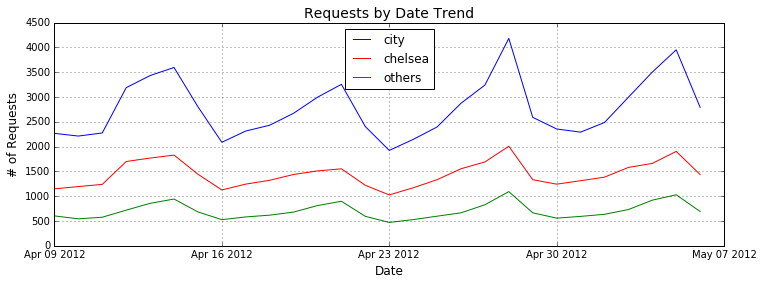

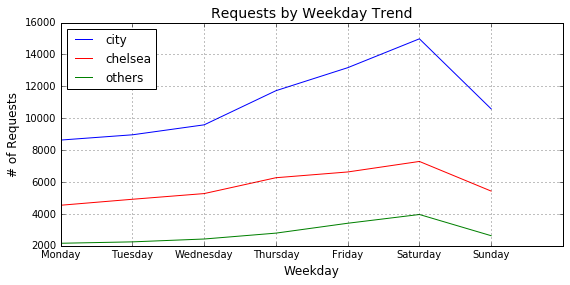

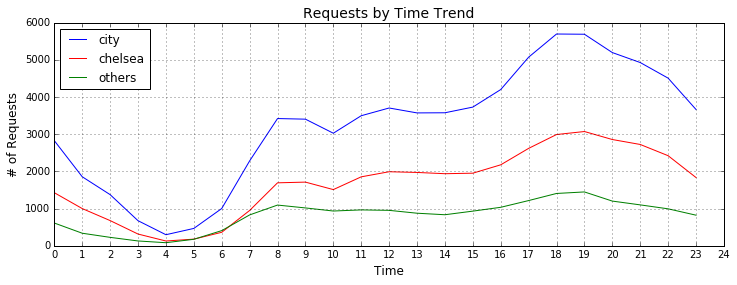

In [8]:
## make requests trend dataframes

weekdays = pd.Series(city_metrics_df['day'].unique())
dates = pd.Series(city_metrics_df['date'].unique())
times = pd.Series(city_metrics_df['time'].unique())


## WEEKDAYS
requests_weekdays_df = pd.DataFrame()
requests_weekdays_df['weekdays'] = weekdays

def make_requests_city_weekdays(row):
    return city_metrics_df[city_metrics_df['day'] == row['weekdays']]['requests'].sum()

def make_requests_chelsea_weekdays(row):
    return trips_df[(trips_df['day'] == row['weekdays']) & (trips_df['start_geo'] == 'Chelsea Court')].shape[0]

def make_requests_others_weekdays(row):
    return trips_df[(trips_df['day'] == row['weekdays']) & (trips_df['start_geo'] != 'Chelsea Court')].shape[0]

requests_weekdays_df['city'] = requests_weekdays_df.apply(make_requests_city_weekdays, axis = 1)
requests_weekdays_df['chelsea'] = requests_weekdays_df.apply(make_requests_chelsea_weekdays, axis = 1)
requests_weekdays_df['others'] = requests_weekdays_df.apply(make_requests_others_weekdays, axis = 1)

## DATES
requests_dates_df = pd.DataFrame()
requests_dates_df['dates'] = dates

def make_requests_city_dates(row):
    return city_metrics_df[city_metrics_df['date'] == row['dates']]['requests'].sum()

def make_requests_chelsea_dates(row):
    return trips_df[(trips_df['date'] == row['dates']) & (trips_df['start_geo'] == 'Chelsea Court')].shape[0]

def make_requests_others_dates(row):
    return trips_df[(trips_df['date'] == row['dates']) & (trips_df['start_geo'] != 'Chelsea Court')].shape[0]

requests_dates_df['city'] = requests_dates_df.apply(make_requests_city_dates, axis = 1)
requests_dates_df['chelsea'] = requests_dates_df.apply(make_requests_chelsea_dates, axis = 1)
requests_dates_df['others'] = requests_dates_df.apply(make_requests_others_dates, axis = 1)

##TIMES
requests_times_df = pd.DataFrame()
requests_times_df['times'] = times

def make_requests_city_times(row):
    return city_metrics_df[city_metrics_df['time'] == row['times']]['requests'].sum()

def make_requests_chelsea_times(row):
    return trips_df[(trips_df['time'] == row['times']) & (trips_df['start_geo'] == 'Chelsea Court')].shape[0]

def make_requests_others_times(row):
    return trips_df[(trips_df['time'] == row['times']) & (trips_df['start_geo'] != 'Chelsea Court')].shape[0]

requests_times_df['city'] = requests_times_df.apply(make_requests_city_times, axis = 1)
requests_times_df['chelsea'] = requests_times_df.apply(make_requests_chelsea_times, axis = 1)
requests_times_df['others'] = requests_times_df.apply(make_requests_others_times, axis = 1)

## Make Trend plots
% matplotlib inline

## plot Dates 

ax1 = requests_dates_df.plot(x='dates', y='city', figsize=(12,4), legend= True, color = 'b', rot = 30)
requests_dates_df.plot(x='dates', y='chelsea', ax=ax1, legend= True, color = 'r')
requests_dates_df.plot(x='dates', y='others', ax=ax1, legend= True, color = 'g')

ax1.grid(b=True, which ='major', linestyle='dotted', linewidth='0.5', color = 'k')
ax1.set_xlabel("Date", fontsize = 12)
ax1.set_ylabel("# of Requests", fontsize = 12)
ax1.set_title("Requests by Date Trend", fontsize = 14)
start, end = ax1.get_xlim()
end += 2
ax1.xaxis.set_ticks(np.arange(start, end, 7))
plt.show()
## plot Weekdays

ax2 = requests_weekdays_df.plot(x='weekdays', y='city', figsize=(9,4), legend= True, color = 'b')
requests_weekdays_df.plot(x='weekdays', y='chelsea', ax=ax2, legend= True, color = 'r')
requests_weekdays_df.plot(x='weekdays', y='others', ax=ax2, legend= True, color = 'g')

ax2.grid(b=True, which ='major', linestyle='dotted', linewidth='0.5', color = 'k')
ax2.set_xlabel("Weekday", fontsize = 12)
ax2.set_ylabel("# of Requests", fontsize = 12)
ax2.set_title("Requests by Weekday Trend", fontsize = 14)
start, end = ax2.get_xlim()
end += 2
ax2.xaxis.set_ticks(np.arange(start, end, 1))
plt.show()
## plot Hours

ax3 = requests_times_df.plot(x='times', y='city', figsize=(12,4), legend= True, color = 'b')
requests_times_df.plot(x='times', y='chelsea', ax=ax3, legend= True, color = 'r')
requests_times_df.plot(x='times', y='others', ax=ax3, legend= True, color = 'g')

ax3.grid(b=True, which ='major', linestyle='dotted', linewidth='0.5', color = 'k')
ax3.set_xlabel("Time", fontsize = 12)
ax3.set_ylabel("# of Requests", fontsize = 12)
ax3.set_title("Requests by Time Trend", fontsize = 14)
start, end = ax3.get_xlim()
end += 2
ax3.xaxis.set_ticks(np.arange(start, end, 1))
plt.show()

## Trends in Completion Rate over Time

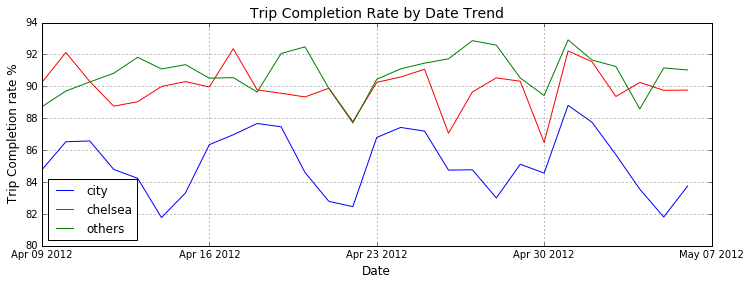

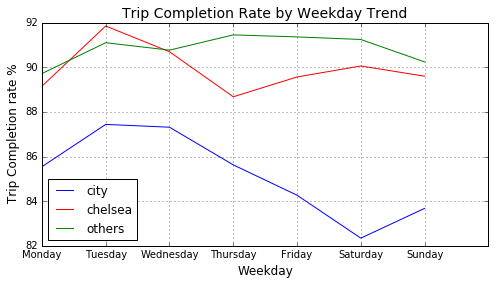

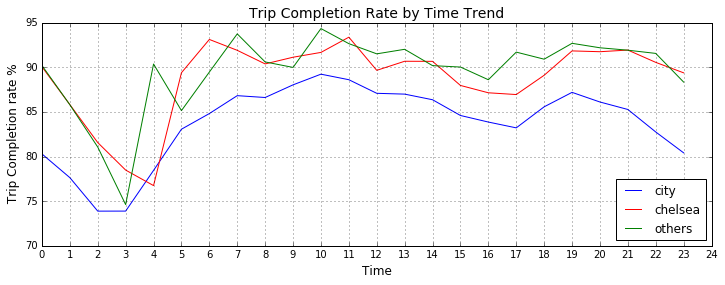

In [9]:
## WEEKDAYS
completion_weekdays_df = pd.DataFrame()
completion_weekdays_df['weekdays'] = weekdays

def make_completion_city_weekdays(row):
    return 100 * (city_metrics_df[city_metrics_df['day'] == row['weekdays']]['trips'].sum() / city_metrics_df[
        city_metrics_df['day'] == row['weekdays']]['requests'].sum())

def make_completion_chelsea_weekdays(row):
    return 100 * (trips_df[
        (trips_df['day'] == row['weekdays']) & 
        (trips_df['start_geo'] == 'Chelsea Court') & (trips_df['trip_status'] == 'completed')].shape[0] / 
                  trips_df[
        (trips_df['day'] == row['weekdays']) & (trips_df['start_geo'] == 'Chelsea Court')].shape[0])

def make_completion_others_weekdays(row):
    return 100 * (trips_df[
        (trips_df['day'] == row['weekdays']) & 
        (trips_df['start_geo'] != 'Chelsea Court') & (trips_df['trip_status'] == 'completed')].shape[0] / 
                  trips_df[
        (trips_df['day'] == row['weekdays']) & (trips_df['start_geo'] != 'Chelsea Court')].shape[0])

completion_weekdays_df['city'] = completion_weekdays_df.apply(make_completion_city_weekdays, axis = 1)
completion_weekdays_df['chelsea'] = completion_weekdays_df.apply(make_completion_chelsea_weekdays, axis = 1)
completion_weekdays_df['others'] = completion_weekdays_df.apply(make_completion_others_weekdays, axis = 1)

## DATES
completion_dates_df = pd.DataFrame()
completion_dates_df['dates'] = dates

def make_completion_city_dates(row):
    return 100 * (city_metrics_df[city_metrics_df['date'] == row['dates']]['trips'].sum() / city_metrics_df[
        city_metrics_df['date'] == row['dates']]['requests'].sum())

def make_completion_chelsea_dates(row):
    return 100 * (trips_df[
        (trips_df['date'] == row['dates']) & 
        (trips_df['start_geo'] == 'Chelsea Court') & (trips_df['trip_status'] == 'completed')].shape[0] / 
                  trips_df[
        (trips_df['date'] == row['dates']) & (trips_df['start_geo'] == 'Chelsea Court')].shape[0])

def make_completion_others_dates(row):
    return 100 * (trips_df[
        (trips_df['date'] == row['dates']) & 
        (trips_df['start_geo'] != 'Chelsea Court') & (trips_df['trip_status'] == 'completed')].shape[0] / 
                  trips_df[
        (trips_df['date'] == row['dates']) & (trips_df['start_geo'] != 'Chelsea Court')].shape[0])

completion_dates_df['city'] = completion_dates_df.apply(make_completion_city_dates, axis = 1)
completion_dates_df['chelsea'] = completion_dates_df.apply(make_completion_chelsea_dates, axis = 1)
completion_dates_df['others'] = completion_dates_df.apply(make_completion_others_dates, axis = 1)

##TIMES
completion_times_df = pd.DataFrame()
completion_times_df['times'] = times

def make_completion_city_times(row):
    return 100 * (city_metrics_df[city_metrics_df['time'] == row['times']]['trips'].sum() / city_metrics_df[
        city_metrics_df['time'] == row['times']]['requests'].sum())

def make_completion_chelsea_times(row):
    return 100 * (trips_df[
        (trips_df['time'] == row['times']) & 
        (trips_df['start_geo'] == 'Chelsea Court') & (trips_df['trip_status'] == 'completed')].shape[0] / 
                  trips_df[
        (trips_df['time'] == row['times']) & (trips_df['start_geo'] == 'Chelsea Court')].shape[0])

def make_completion_others_times(row):
    return 100 * (trips_df[
        (trips_df['time'] == row['times']) & 
        (trips_df['start_geo'] != 'Chelsea Court') & (trips_df['trip_status'] == 'completed')].shape[0] / 
                  trips_df[
        (trips_df['time'] == row['times']) & (trips_df['start_geo'] != 'Chelsea Court')].shape[0])

completion_times_df['city'] = completion_times_df.apply(make_completion_city_times, axis = 1)
completion_times_df['chelsea'] = completion_times_df.apply(make_completion_chelsea_times, axis = 1)
completion_times_df['others'] = completion_times_df.apply(make_completion_others_times, axis = 1)

## Make Trend plots
% matplotlib inline

## plot Dates 

ax1 = completion_dates_df.plot(x='dates', y='city', figsize=(12,4), legend= True, color = 'b', rot = 30)
completion_dates_df.plot(x='dates', y='chelsea', ax=ax1, legend= True, color = 'r')
completion_dates_df.plot(x='dates', y='others', ax=ax1, legend= True, color = 'g')

ax1.grid(b=True, which ='major', linestyle='dotted', linewidth='0.5', color = 'k')
ax1.set_xlabel("Date", fontsize = 12)
ax1.set_ylabel(" Trip Completion rate %", fontsize = 12)
ax1.set_title("Trip Completion Rate by Date Trend", fontsize = 14)
start, end = ax1.get_xlim()
end += 2
ax1.xaxis.set_ticks(np.arange(start, end, 7))
plt.show()
## plot Weekdays

ax2 = completion_weekdays_df.plot(x='weekdays', y='city', figsize=(8,4), legend= True, color = 'b')
completion_weekdays_df.plot(x='weekdays', y='chelsea', ax=ax2, legend= True, color = 'r')
completion_weekdays_df.plot(x='weekdays', y='others', ax=ax2, legend= True, color = 'g')

ax2.grid(b=True, which ='major', linestyle='dotted', linewidth='0.5', color = 'k')
ax2.set_xlabel("Weekday", fontsize = 12)
ax2.set_ylabel(" Trip Completion rate %", fontsize = 12)
ax2.set_title("Trip Completion Rate by Weekday Trend", fontsize = 14)
start, end = ax2.get_xlim()
end += 2
ax2.xaxis.set_ticks(np.arange(start, end, 1))
plt.show()
## plot Hours

ax3 = completion_times_df.plot(x='times', y='city', figsize=(12,4), legend= True, color = 'b')
completion_times_df.plot(x='times', y='chelsea', ax=ax3, legend= True, color = 'r')
completion_times_df.plot(x='times', y='others', ax=ax3, legend= True, color = 'g')

ax3.grid(b=True, which ='major', linestyle='dotted', linewidth='0.5', color = 'k')
ax3.set_xlabel("Time", fontsize = 12)
ax3.set_ylabel(" Trip Completion rate %", fontsize = 12)
ax3.set_title("Trip Completion Rate by Time Trend", fontsize = 14)
start, end = ax3.get_xlim()
end += 2
ax3.xaxis.set_ticks(np.arange(start, end, 1))
plt.show()

## Trends in Surge over Time

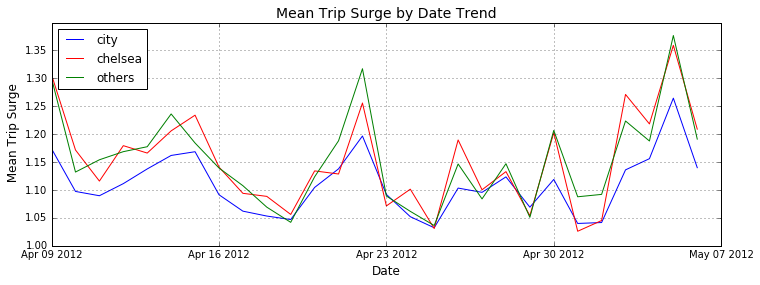

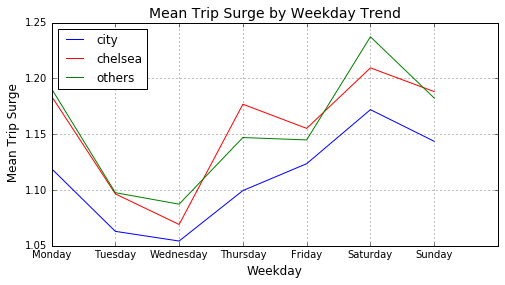

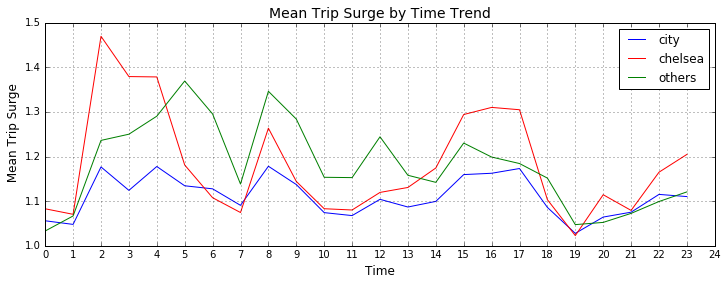

In [10]:
## make requests trend dataframes

weekdays = pd.Series(city_metrics_df['day'].unique())
dates = pd.Series(city_metrics_df['date'].unique())
times = pd.Series(city_metrics_df['time'].unique())


## WEEKDAYS
surge_weekdays_df = pd.DataFrame()
surge_weekdays_df['weekdays'] = weekdays

def make_surge_city_weekdays(row):
    return city_metrics_df[city_metrics_df['day'] == row['weekdays']]['mean_surge_multipler'].mean()

def make_surge_chelsea_weekdays(row):
    return trips_df[
        (trips_df['day'] == row['weekdays']) & 
        (trips_df['start_geo'] == 'Chelsea Court')]['surge_multiplier'].mean()

def make_surge_others_weekdays(row):
    return trips_df[
        (trips_df['day'] == row['weekdays']) & 
        (trips_df['start_geo'] != 'Chelsea Court')]['surge_multiplier'].mean()

surge_weekdays_df['city'] = surge_weekdays_df.apply(make_surge_city_weekdays, axis = 1)
surge_weekdays_df['chelsea'] = surge_weekdays_df.apply(make_surge_chelsea_weekdays, axis = 1)
surge_weekdays_df['others'] = surge_weekdays_df.apply(make_surge_others_weekdays, axis = 1)

## DATES
surge_dates_df = pd.DataFrame()
surge_dates_df['dates'] = dates

def make_surge_city_dates(row):
    return city_metrics_df[city_metrics_df['date'] == row['dates']]['mean_surge_multipler'].mean()

def make_surge_chelsea_dates(row):
    return trips_df[
        (trips_df['date'] == row['dates']) & 
        (trips_df['start_geo'] == 'Chelsea Court')]['surge_multiplier'].mean()

def make_surge_others_dates(row):
    return trips_df[
        (trips_df['date'] == row['dates']) & 
        (trips_df['start_geo'] != 'Chelsea Court')]['surge_multiplier'].mean()

surge_dates_df['city'] = surge_dates_df.apply(make_surge_city_dates, axis = 1)
surge_dates_df['chelsea'] = surge_dates_df.apply(make_surge_chelsea_dates, axis = 1)
surge_dates_df['others'] = surge_dates_df.apply(make_surge_others_dates, axis = 1)

##TIMES
surge_times_df = pd.DataFrame()
surge_times_df['times'] = times

def make_surge_city_times(row):
    return city_metrics_df[city_metrics_df['time'] == row['times']]['mean_surge_multipler'].mean()

def make_surge_chelsea_times(row):
    return trips_df[
        (trips_df['time'] == row['times']) & 
        (trips_df['start_geo'] == 'Chelsea Court')]['surge_multiplier'].mean()

def make_surge_others_times(row):
    return trips_df[
        (trips_df['time'] == row['times']) & 
        (trips_df['start_geo'] != 'Chelsea Court')]['surge_multiplier'].mean()

surge_times_df['city'] = surge_times_df.apply(make_surge_city_times, axis = 1)
surge_times_df['chelsea'] = surge_times_df.apply(make_surge_chelsea_times, axis = 1)
surge_times_df['others'] = surge_times_df.apply(make_surge_others_times, axis = 1)

## Make Trend plots

% matplotlib inline

## plot Dates 

ax1 = surge_dates_df.plot(x='dates', y='city', figsize=(12,4), legend= True, color = 'b', rot = 30)
surge_dates_df.plot(x='dates', y='chelsea', ax=ax1, legend= True, color = 'r')
surge_dates_df.plot(x='dates', y='others', ax=ax1, legend= True, color = 'g')

ax1.grid(b=True, which ='major', linestyle='dotted', linewidth='0.5', color = 'k')
ax1.set_xlabel("Date", fontsize = 12)
ax1.set_ylabel(" Mean Trip Surge", fontsize = 12)
ax1.set_title("Mean Trip Surge by Date Trend", fontsize = 14)
start, end = ax1.get_xlim()
end += 2
ax1.xaxis.set_ticks(np.arange(start, end, 7))
plt.show()

## plot Weekdays

ax2 = surge_weekdays_df.plot(x='weekdays', y='city', figsize=(8,4), legend= True, color = 'b')
surge_weekdays_df.plot(x='weekdays', y='chelsea', ax=ax2, legend= True, color = 'r')
surge_weekdays_df.plot(x='weekdays', y='others', ax=ax2, legend= True, color = 'g')

ax2.grid(b=True, which ='major', linestyle='dotted', linewidth='0.5', color = 'k')
ax2.set_xlabel("Weekday", fontsize = 12)
ax2.set_ylabel(" Mean Trip Surge", fontsize = 12)
ax2.set_title("Mean Trip Surge by Weekday Trend", fontsize = 14)
start, end = ax2.get_xlim()
end += 2
ax2.xaxis.set_ticks(np.arange(start, end, 1))
plt.show()

## plot Hours

ax3 = surge_times_df.plot(x='times', y='city', figsize=(12,4), legend= True, color = 'b')
surge_times_df.plot(x='times', y='chelsea', ax=ax3, legend= True, color = 'r')
surge_times_df.plot(x='times', y='others', ax=ax3, legend= True, color = 'g')

ax3.grid(b=True, which ='major', linestyle='dotted', linewidth='0.5', color = 'k')
ax3.set_xlabel("Time", fontsize = 12)
ax3.set_ylabel(" Mean Trip Surge", fontsize = 12)
ax3.set_title("Mean Trip Surge by Time Trend", fontsize = 14)
start, end = ax3.get_xlim()
end += 2
ax3.xaxis.set_ticks(np.arange(start, end, 1))
plt.show()

## Trends in ETA over Time

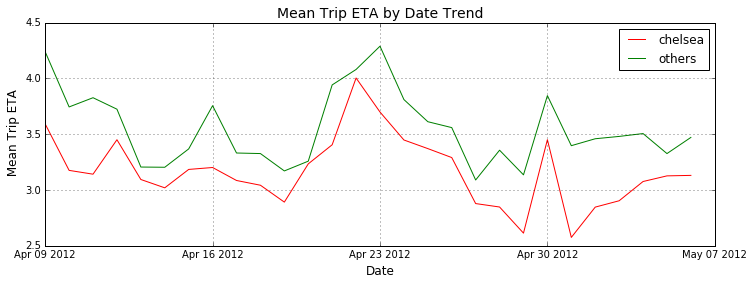

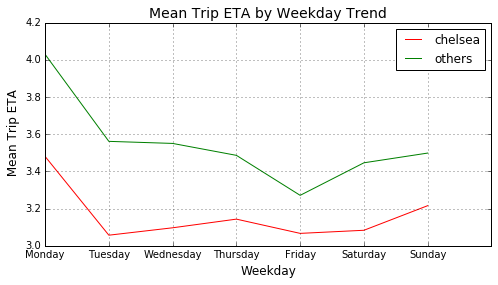

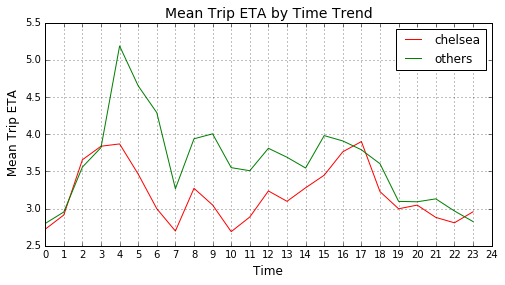

In [11]:
## make requests trend dataframes

weekdays = pd.Series(city_metrics_df['day'].unique())
dates = pd.Series(city_metrics_df['date'].unique())
times = pd.Series(city_metrics_df['time'].unique())


## WEEKDAYS
ETA_weekdays_df = pd.DataFrame()
ETA_weekdays_df['weekdays'] = weekdays

def make_ETA_chelsea_weekdays(row):
    return trips_df[
        (trips_df['day'] == row['weekdays']) & (trips_df['start_geo'] == 'Chelsea Court')][
        'estimated_time_to_arrival'].mean()

def make_ETA_others_weekdays(row):
    return trips_df[
        (trips_df['day'] == row['weekdays']) & (trips_df['start_geo'] != 'Chelsea Court')][
        'estimated_time_to_arrival'].mean()

ETA_weekdays_df['chelsea'] = ETA_weekdays_df.apply(make_ETA_chelsea_weekdays, axis = 1)
ETA_weekdays_df['others'] = ETA_weekdays_df.apply(make_ETA_others_weekdays, axis = 1)

## DATES
ETA_dates_df = pd.DataFrame()
ETA_dates_df['dates'] = dates

def make_ETA_chelsea_dates(row):
    return trips_df[
        (trips_df['date'] == row['dates']) & (trips_df['start_geo'] == 'Chelsea Court')][
        'estimated_time_to_arrival'].mean()

def make_ETA_others_dates(row):
    return trips_df[
        (trips_df['date'] == row['dates']) & (trips_df['start_geo'] != 'Chelsea Court')][
        'estimated_time_to_arrival'].mean()

ETA_dates_df['chelsea'] = ETA_dates_df.apply(make_ETA_chelsea_dates, axis = 1)
ETA_dates_df['others'] = ETA_dates_df.apply(make_ETA_others_dates, axis = 1)

##TIMES
ETA_times_df = pd.DataFrame()
ETA_times_df['times'] = times

def make_ETA_chelsea_times(row):
    return trips_df[
        (trips_df['time'] == row['times']) & (trips_df['start_geo'] == 'Chelsea Court')][
        'estimated_time_to_arrival'].mean()

def make_ETA_others_times(row):
    return trips_df[
        (trips_df['time'] == row['times']) & (trips_df['start_geo'] != 'Chelsea Court')][
        'estimated_time_to_arrival'].mean()

ETA_times_df['chelsea'] = ETA_times_df.apply(make_ETA_chelsea_times, axis = 1)
ETA_times_df['others'] = ETA_times_df.apply(make_ETA_others_times, axis = 1)

## Make Trend plots
% matplotlib inline

## plot Dates 

ax1 = ETA_dates_df.plot(x='dates', y='chelsea', figsize=(12,4), legend= True, color = 'r', rot = 30)
ETA_dates_df.plot(x='dates', y='others', ax=ax1, legend= True, color = 'g')

ax1.grid(b=True, which ='major', linestyle='dotted', linewidth='0.5', color = 'k')
ax1.set_xlabel("Date", fontsize = 12)
ax1.set_ylabel(" Mean Trip ETA", fontsize = 12)
ax1.set_title("Mean Trip ETA by Date Trend", fontsize = 14)
start, end = ax1.get_xlim()
end += 2
ax1.xaxis.set_ticks(np.arange(start, end, 7))
plt.show()
## plot Weekdays

ax2 = ETA_weekdays_df.plot(x='weekdays', y='chelsea', figsize=(8,4), legend= True, color = 'r')
ETA_weekdays_df.plot(x='weekdays', y='others', ax=ax2, legend= True, color = 'g')

ax2.grid(b=True, which ='major', linestyle='dotted', linewidth='0.5', color = 'k')
ax2.set_xlabel("Weekday", fontsize = 12)
ax2.set_ylabel(" Mean Trip ETA", fontsize = 12)
ax2.set_title("Mean Trip ETA by Weekday Trend", fontsize = 14)
start, end = ax2.get_xlim()
end += 2
ax2.xaxis.set_ticks(np.arange(start, end, 1))
plt.show()
## plot Hours

ax3 = ETA_times_df.plot(x='times', y='chelsea', figsize=(8,4), legend= True, color = 'r')
ETA_times_df.plot(x='times', y='others', ax=ax3, legend= True, color = 'g')

ax3.grid(b=True, which ='major', linestyle='dotted', linewidth='0.5', color = 'k')
ax3.set_xlabel("Time", fontsize = 12)
ax3.set_ylabel(" Mean Trip ETA", fontsize = 12)
ax3.set_title("Mean Trip ETA by Time Trend", fontsize = 14)
start, end = ax3.get_xlim()
end += 2
ax3.xaxis.set_ticks(np.arange(start, end, 1))
plt.show()

There is some weekly seasonality to the trends in requests made across the specified period, but no discernible growth trend, and simple eyeballing gauges that there is no need to deep dive into cleaning out seasonality from the time series to see the trend, although, if we had more data (1 year +), some decomposition & forecasting would be a worthwhile exercise to undertake. 

Trends show that rides from Chelsea Court make up most of City X’s requests, confirming the GM’s analysis. There is actually a higher Estimated Time to Arrival (ETA) in rides from the other 3 neighborhoods in the GOI than from Chelsea Court. However, as the data shows only requests that were made, and not all rides that were input (as riders could be turned off by high ETAs and Surge Times and not make requests), this could be misleading.

Requests made per day peak on Fridays and Saturdays. Conversely, trip completion is lowest in the city on Friday and Saturday (82%), peaking at almost 88% on Tuesday and Wednesday across City X. Saturday shows the highest surge multiplier rates in the city, with the lowest in Tuesdays and Wednesdays

Chelsea Court shows its highest volume of requests and surge multipliers, as well as a peak in ETA, in the evening rush hour period. Surge rates peak at 5:00PM, as well as ETAs, and then reduce as the evening wears on, although the volume of requests stays high, indicating that our riders might be doing well to respond to the initial surge. There are actually higher surges, and ETAs in the morning rush hour (between 7:00PM and 10:00PM), in the other neighborhoods than in Chelsea Court. This is due to direction of traffic, as the riders who cause the evening rush hour surge from Chelsea Court go there from other neighborhoods in the morning.


# Define Metrics For Promotion Effect Analysis

Gauging the effect of the promotion on our Marketplace dynamics, and by extension, our finances and revenue, would require us to determine some metrics first. We can hypothesise how these metrics would be affected (or not affected) by the promotion, and use this as a key starting point for our analysis.

The first key metric is requests, and request rate. We want to know if we are getting more requests due to the promotion, within the boundaries of the promotion (rides from Chelsea Court on Monday to friday with surge multiplier > 1.2, defined as our surge cutoff), but also, we can measure this using request rates, defined as the average number of requests made per rider in a segment of our population during the period.

The second metric, closely tied to the first, is trip completion rate, defined as the number or requested trips that get completed (unfulfilled and failed trips are negligible in the data set, so we can assume that the complement of completed trips is rider cancelled trips). Does our promotion encourage more completed trips, and hence more revenue?

Finally, we are looking at metric regarding user acquisition. As we do not have the data from previous time periods and seasons to compare growth in rider acquisition (here, we are measuring first trips taken as acquisition, vs signups), we have to evaluate this metric against itself during the period. One way is by measuring retention rates, where retained riders are defined as riders who took their first trip within the period, and have completed more trips after the period. 

In [12]:
## Mark First time Riders 

surge_cutoff = trips_df[trips_df['trip_price_pre_discount'] > trips_df['rider_payment']][
    'surge_multiplier'].min()

promo_segment = trips_df[(trips_df['start_geo'] == 'Chelsea Court') & 
                             (~trips_df['day'].isin(['Saturday','Sunday']) &
                             (trips_df['surge_multiplier'] >= surge_cutoff))]

def make_new_conversion_rider(row):
    if (row['first_completed_trip'] >= trips_df['request_time'].min()) & (
        row['first_completed_trip'] <= (trips_df['request_time'].max() + timedelta(days = 1))):
        return 1
    else:
        return 0
    
def make_retained_users_rider(row):
    if (row['first_completed_trip'] >= trips_df['request_time'].min()) & (
        row['first_completed_trip'] <= (trips_df['request_time'].max() + timedelta(days = 1))) & (
        row['lifetime_trips'] != 1):
        return 1
    else:
        return 0
    
def make_period_requests(row):
    return trips_df[trips_df['rider_id'] == row['rider_id']].shape[0]

def make_segment_requests(row):
    return promo_segment[promo_segment['rider_id'] == row['rider_id']].shape[0]

    
first_trip_in_period = pd.DataFrame(trips_df[['rider_id','request_time']].groupby(
        ['rider_id']).max().reset_index())


## apply to riders df

rider_data_df['new_user_in_period'] = rider_data_df.apply(make_new_conversion_rider, axis = 1)
rider_data_df['retained_user_from_period'] = rider_data_df.apply(make_retained_users_rider, axis = 1)
rider_data_df['period_requests'] = rider_data_df.apply(make_period_requests, axis = 1)
rider_data_df['segment_requests'] = rider_data_df.apply(make_segment_requests, axis = 1)
rider_data_df = rider_data_df.merge(
    first_trip_in_period, left_on = 'rider_id', right_on = 'rider_id', how = 'left')

In [13]:
## apply to trips df

new_users = rider_data_df[rider_data_df['new_user_in_period'] == 1]['rider_id'].tolist()
retained_riders = rider_data_df[rider_data_df['retained_user_from_period'] == 1]['rider_id'].tolist()

## Mark stuff in Trips_df

def make_promotion_trips(row):
    if (row['trip_price_pre_discount'] - row['rider_payment']) > 0:
        return 1
    else:
        return 0

def make_new_user_trips(row):
    if row['rider_id'] in new_users:
        return 1
    else:
        return 0
    
def make_retained_user_trips(row):
    if row['rider_id'] in retained_riders:
        return 1
    else:
        return 0

trips_df['promotion_used'] = trips_df.apply(make_promotion_trips, axis = 1)
trips_df['new_user'] = trips_df.apply(make_new_user_trips, axis = 1)
trips_df['retained_user'] = trips_df.apply(make_retained_user_trips, axis = 1)

trips_cols = list(trips_df.columns.values)
trips_cols.append('request_time_')
trips_df = trips_df.merge(rider_data_df, left_on = 'rider_id', right_on = 'rider_id', how = 'left', 
                          suffixes = ('','_'))[trips_cols]
trips_df.rename(columns = {'request_time_':'first_trip_time'}, inplace = True)

trips_df['first_trip'] = np.where((trips_df['request_time'] == trips_df['first_trip_time']), 1, 0)

promo_ids = trips_df[trips_df['promotion_used'] == 1]['rider_id'].unique()
rider_data_df['opt_in'] = np.where(rider_data_df['rider_id'].isin(promo_ids), 1, 0)

promo_users = rider_data_df[rider_data_df['opt_in'] == 1]['rider_id'].tolist()
trips_df['opt_in'] = np.where((trips_df['rider_id'].isin(promo_users)), 1, 0)

# Promotion Effect Hypothesis Testing

Testing conversion rate and retention rate is ordinal in nature: a rider segment either (1) opts in to the promo or (2) does not, and the outcomes are binary in nature. As such, a chi-squared test would be suitable for testing these, to evaluate the effect of the promotion. 

On the other hand, measuring requests per rider is a measure of population means, and a 2-sample t-test should work for this. A challenge to this is that our data, by nature, is not a normal distribution, which is a requirement for t-tests. However, Central Limit Theorem is  a friend here- by randomly sampling our data over n-user defined repetitions, and taking the mean of each sample, these means, uder CLT, would fit a normal distribution, and thus be appropriate for us to t-test.

In [14]:
def make_contingency_table(df, hyp_metric, hyp_col):
    top = [None]*2
    bottom = [None]*2
    output = [top,bottom]
    if hyp_metric == 'completion rate':
        top[0] = df[(df[hyp_col] == 1)].shape[0]
        top[1] = df[(df[hyp_col] == 0)].shape[0]
        bottom[0] = df[(df[hyp_col] == 1) & (df['trip_status'] == 'completed')].shape[0]
        bottom[1] = df[(df[hyp_col] == 0) & (df['trip_status'] == 'completed')].shape[0]
    elif hyp_metric == 'retention rate':
        top[0] = df[(df[hyp_col] == 1) & (df['new_user'] == 1)]['rider_id'].nunique()
        top[1] = df[(df[hyp_col] == 0) & (df['new_user'] == 1)]['rider_id'].nunique()
        bottom[0] = df[(df[hyp_col] == 1) & (df['new_user'] == 1) &
                         (df['retained_user'] == 1)]['rider_id'].nunique()
        bottom[1] = df[(df[hyp_col] == 0) & (df['new_user'] == 1) &
                         (df['retained_user'] == 1)]['rider_id'].nunique()
    return output

def make_chi_squared_results(df, hyp_metric, hyp_col, prob):
    # contingency table
    table = make_contingency_table(df, hyp_metric, hyp_col)
    stat, p, dof, expected = chi2_contingency(table)

    # interpret test-statistic
    
    critical = chi2.ppf(prob, dof)
    line1 = 'probability=%.3f, critical=%.3f, stat=%.3f, ' % (prob, critical, stat)
    
    if abs(stat) >= critical:
        line2 = 'Dependent (reject H0);'
    else:
        line2 = 'Independent (fail to reject H0);'
        
    # interpret p-value
    alpha = 1.0 - prob
    line3 = 'significance=%.3f, p=%.3f, ' % (alpha, p)
    
    if p <= alpha:
        line4 = 'Dependent (reject H0)'
    else:
        line4 = 'Independent (fail to reject H0)'
        
    return str(line1+line2), str(line3+line4)

def CLT_dist(input_series, repetitions, smaller_series):
    sample_size = int(smaller_series.count())
    means = []
    i = 0
    while i < repetitions:
        sample = input_series.sample(n=sample_size, random_state=1)
        new_mean = sample.mean()
        means.append(new_mean)
        i += 1
        
    return means

def my_t_test(data1, data2):
    twosample_results = ttest_ind(data1, data2)
    test_statistic = twosample_results[0]
    p_value = twosample_results[1]
    line1 = 'test statistic=%.3f, p_value=%.3f, ' % (test_statistic, p_value)
    if p_value < test_statistic:
        line2 = '(reject H0)'
    else:
        line2 = '(fail to reject H0)'
    return str(line1+line2)
    

## Chi-Squared Testing

For our chi-squared tests, we will look at trip completion rate, and new user retention rate, for promo vs non-promo riders, across (1) the entire population of surged requests and all riders; (2) trips made in our promo segment (M->F from Chelsea Court during surge > 1.2), and (3) the population of surged trips where the promotion was not applied.

In [15]:
# Make segments to chi-squared test
surge_trips_all_df = trips_df[trips_df['surge_multiplier'] >= surge_cutoff]
surge_trips_segment_df = surge_trips_all_df[(surge_trips_all_df['start_geo'] == 'Chelsea Court') & 
                                                (~surge_trips_all_df['day'].isin(['Saturday','Sunday']))]
surge_trips_outside_df = surge_trips_all_df[(surge_trips_all_df['start_geo'] == 'Chelsea Court') & 
                                                (surge_trips_all_df['day'].isin(['Saturday','Sunday']))]


In [16]:
## View Metrics in segment
def completion_rate(df,value,col):
    numerator = df[(df[col] == value) & (df['trip_status'] == 'completed')].shape[0]
    denominator = df[df[col] == value].shape[0]
    return (numerator/denominator)

print('Surge Trip Completion Rate is ' + str(completion_rate(surge_trips_all_df,1,'opt_in')) + 
                                                   ' for riders who opted-in in the GOI')
print('Surge Trip Completion Rate is ' + str(completion_rate(surge_trips_all_df,0,'opt_in')) + 
                                                   ' for riders who did not opt-in in the GOI')
print('Surge Trip Completion Rate is ' + str(completion_rate(surge_trips_segment_df,1,'promotion_used')) + 
                                                   ' for riders who opted in in Chelsea Court on M -> F')
print('Surge Trip Completion Rate is ' + str(completion_rate(surge_trips_segment_df,0,'promotion_used')) + 
                                                   ' for riders who did not opt-in in Chelsea Court on M -> F')
print('Surge Trip Completion Rate is ' + str(completion_rate(surge_trips_outside_df,1,'opt_in')) + 
                                                   ' for riders who opted in in Chelsea Court on weekends')
print('Surge Trip Completion Rate is ' + str(completion_rate(surge_trips_outside_df,0,'opt_in')) + 
                                                   ' for riders who did not opt-in in Chelsea Court on weekends')


Surge Trip Completion Rate is 0.9624145785876993 for riders who opted-in in the GOI
Surge Trip Completion Rate is 0.8508512508992087 for riders who did not opt-in in the GOI
Surge Trip Completion Rate is 0.972520908004779 for riders who opted in in Chelsea Court on M -> F
Surge Trip Completion Rate is 0.7527014510651435 for riders who did not opt-in in Chelsea Court on M -> F
Surge Trip Completion Rate is 0.8709677419354839 for riders who opted in in Chelsea Court on weekends
Surge Trip Completion Rate is 0.8763644992880874 for riders who did not opt-in in Chelsea Court on weekends


In [17]:
# Apply chi-square tests for Completion Rates

print('Completion Rate across all data : ' 
      + str(make_chi_squared_results(surge_trips_all_df, 'completion rate', 'opt_in', 0.95)))
print('Completion Rate from Chelsea Court during Weekdays : ' + 
      str(make_chi_squared_results(surge_trips_segment_df, 'completion rate', 'promotion_used', 0.95)))
print('Completion Rate from Chelsea Court during Weekends : ' + 
      str(make_chi_squared_results(surge_trips_outside_df, 'completion rate', 'opt_in', 0.95)))

Completion Rate across all data : ('probability=0.950, critical=3.841, stat=20.009, Dependent (reject H0);', 'significance=0.050, p=0.000, Dependent (reject H0)')
Completion Rate from Chelsea Court during Weekdays : ('probability=0.950, critical=3.841, stat=49.373, Dependent (reject H0);', 'significance=0.050, p=0.000, Dependent (reject H0)')
Completion Rate from Chelsea Court during Weekends : ('probability=0.950, critical=3.841, stat=0.004, Independent (fail to reject H0);', 'significance=0.050, p=0.952, Independent (fail to reject H0)')


In [18]:
## View Metrics in segment

def retention_rate(df,value):
    numerator = df[(df['opt_in'] == value) & (df['new_user'] == 1) & (df['retained_user'] == 1)][
        'rider_id'].nunique()
    denominator = df[(df['opt_in'] == value) & (df['new_user'] == 1)]['rider_id'].nunique()
    return (numerator/denominator)

print('Surge time Trip retention Rate is ' + str(retention_rate(trips_df,1)) + 
                                                   ' for riders who opted-in in the GOI')
print('Surge time Trip retention Rate is ' + str(retention_rate(trips_df,0)) + 
                                                   ' for riders who did not opt-in in the GOI')


Surge time Trip retention Rate is 0.9112903225806451 for riders who opted-in in the GOI
Surge time Trip retention Rate is 0.8591989987484355 for riders who did not opt-in in the GOI


In [19]:
print('Retention Rate across all data : ' + 
      str(make_chi_squared_results(surge_trips_all_df, 'retention rate', 'opt_in', 0.95)))


Retention Rate across all data : ('probability=0.950, critical=3.841, stat=0.189, Independent (fail to reject H0);', 'significance=0.050, p=0.664, Independent (fail to reject H0)')


## 2-Sample t-test

For our t-test tests, we will look at request rate, for promo vs non-promo riders, across (1) the entire population of requests and all riders; (2) the entire population of requests made by new riders acquired within the period, to control for the biases from existing rider behaviour, and (3) the population of requests made during the bounds of the promotion (M->F trips originating from Chelsea Court when surge > 1.2)

In [20]:
## define_segments to t-test

promo_riders_all = rider_data_df[rider_data_df['opt_in'] == 1]['period_requests']
not_promo_riders_all = rider_data_df[rider_data_df['opt_in'] != 1]['period_requests']

promo_riders_new = rider_data_df[(rider_data_df['opt_in'] == 1) & 
                                 (rider_data_df['new_user_in_period'] == 1)]['period_requests']
not_promo_riders_new = rider_data_df[(rider_data_df['opt_in'] != 1) & 
                                 (rider_data_df['new_user_in_period'] == 1)]['period_requests']

promo_riders_segment = rider_data_df[rider_data_df['opt_in'] == 1]['segment_requests']
not_promo_riders_segment = rider_data_df[rider_data_df['opt_in'] != 1]['segment_requests']


In [21]:
## Get request rate for segments

print('Across the entire period and GOI, opt-in riders made ' + str(promo_riders_all.mean()) + 
      ' requests per rider')
print('Across the entire period and GOI, non opt-in riders made ' + str(not_promo_riders_all.mean()) +
      ' requests per rider')
print('Across the entire period and GOI, newly acquired opt-in riders made ' + 
      str(promo_riders_new.mean()) + ' requests per rider')
print('Across the entire period and GOI, newly acquired opt-in riders made ' + 
      str(not_promo_riders_new.mean()) + ' requests per rider')
print('opt-in riders from Chelsea on M -> F made ' + str(promo_riders_segment.mean()) + 
      ' requests per rider during surge times')
print('non opt-in riders from Chelsea on M -> F made ' + str(not_promo_riders_segment.mean()) + 
      ' requests per rider during surge times')


Across the entire period and GOI, opt-in riders made 1.2874655225252836 requests per rider
Across the entire period and GOI, non opt-in riders made 1.134526106035232 requests per rider
Across the entire period and GOI, newly acquired opt-in riders made 1.1209677419354838 requests per rider
Across the entire period and GOI, newly acquired opt-in riders made 1.0438047559449313 requests per rider
opt-in riders from Chelsea on M -> F made 1.0337113086117071 requests per rider during surge times
non opt-in riders from Chelsea on M -> F made 0.06804739999576029 requests per rider during surge times


In [37]:
## t-test on all riders

promo_riders_all_means = CLT_dist(promo_riders_all, 100, promo_riders_all)
not_promo_riders_all_means = CLT_dist(not_promo_riders_all, 100, promo_riders_all)

print('Requests across all riders : ' + my_t_test(promo_riders_all_means, not_promo_riders_all_means))

Requests across all riders : test statistic=5175740685623270.000, p_value=0.000, (reject H0)


In [36]:
## t-test on new riders

promo_riders_new_means = CLT_dist(promo_riders_new, 100, promo_riders_new)
not_promo_riders_new_means = CLT_dist(not_promo_riders_new, 100, promo_riders_new)

print('Requests within new riders: ' + my_t_test(promo_riders_new_means, not_promo_riders_new_means))

Requests within new riders: test statistic=808054566362665.875, p_value=0.000, (reject H0)


In [38]:
## t-test on riders within segment where promo was applied

promo_riders_segment_means = CLT_dist(promo_riders_segment, 100, promo_riders_segment)
not_promo_riders_segment_means = CLT_dist(not_promo_riders_segment, 100, promo_riders_segment)

print('Requests across segment riders : ' + my_t_test(promo_riders_segment_means, 
                                                      not_promo_riders_segment_means))

Requests across segment riders : test statistic=42897139223766528.000, p_value=0.000, (reject H0)


# Relationships 


In [30]:
code_stamps = []
for i in range (0,7):
    hour_stamps = trips_df['time'].unique()
    for j in hour_stamps:
        if j < 10:
            code_stamps.append(str(i+1)+str(0)+str(j))
        else:
            code_stamps.append(str(i+1)+str(j))

code_stamps.sort()

## Add code_stamp to trips_df

def make_code_stamp(row):
    if row['time'] < 10:
        suffix = str(0)+str(row['time'])
    else:
        suffix = str(row['time'])
    week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    return str(week.index(row['day'])+1)+suffix

trips_df['code_stamp'] = trips_df.apply(make_code_stamp, axis = 1)
city_metrics_df['code_stamp'] = city_metrics_df.apply(make_code_stamp, axis = 1)

In [31]:
relationship_df = pd.DataFrame()
relationship_df['code_stamp'] = pd.Series(code_stamps)

def add_supply(row):
    return city_metrics_df[city_metrics_df['code_stamp'] == row['code_stamp']]['supply_hours'].mean()

def add_city_requests(row):
    return city_metrics_df[city_metrics_df['code_stamp'] == row['code_stamp']]['requests'].mean()
def add_city_trips(row):
    return city_metrics_df[city_metrics_df['code_stamp'] == row['code_stamp']]['trips'].mean()
def add_city_surge(row):
    return city_metrics_df[city_metrics_df['code_stamp'] == row['code_stamp']][
        'mean_surge_multipler'].mean()

chelsea_df = trips_df[(trips_df['start_geo']=='Chelsea Court')]

def add_chelsea_requests(row):
    numerator = chelsea_df[chelsea_df['code_stamp'] == row['code_stamp']].shape[0]
    denominator = chelsea_df[chelsea_df['code_stamp'] == row['code_stamp']]['date'].nunique()
    if denominator == 0:
        return city_metrics_df[city_metrics_df['code_stamp'] == row['code_stamp']]['requests'].mean()
    else:
        return numerator / denominator
    
def add_chelsea_trips(row):
    numerator = chelsea_df[(chelsea_df['code_stamp'] == row['code_stamp']) & 
                    (chelsea_df['trip_status'] == 'completed')].shape[0]
    denominator = chelsea_df[(chelsea_df['code_stamp'] == row['code_stamp']) & 
        (chelsea_df['trip_status'] == 'completed')]['date'].nunique()
    if denominator == 0:
        return city_metrics_df[city_metrics_df['code_stamp'] == row['code_stamp']]['trips'].mean()
    else:
        return numerator/denominator
    
def add_chelsea_surge(row):
    if chelsea_df[chelsea_df['code_stamp'] == row['code_stamp']]['date'].nunique() == 0:
        return 1
    else:
        return chelsea_df[chelsea_df['code_stamp'] == row['code_stamp']]['surge_multiplier'].mean()
    
def add_chelsea_eta(row):
    if chelsea_df[chelsea_df['code_stamp'] == row['code_stamp']]['date'].nunique() == 0:
        return 0
    else:
        return chelsea_df[chelsea_df['code_stamp'] == row['code_stamp']][
            'estimated_time_to_arrival'].mean()

relationship_df['supply_hours'] = relationship_df.apply(add_supply, axis = 1)

relationship_df['city_requests'] = relationship_df.apply(add_city_requests, axis = 1)
relationship_df['city_trips'] = relationship_df.apply(add_city_trips, axis = 1)
relationship_df['city_surge'] = relationship_df.apply(add_city_surge, axis = 1)
relationship_df['city_completion'] = relationship_df['city_trips']/relationship_df['city_requests']

relationship_df['chelsea_requests'] = relationship_df.apply(add_chelsea_requests, axis = 1)
relationship_df['chelsea_trips'] = relationship_df.apply(add_chelsea_trips, axis = 1)
relationship_df['chelsea_surge'] = relationship_df.apply(add_chelsea_surge, axis = 1)
relationship_df['chelsea_eta'] = relationship_df.apply(add_chelsea_eta, axis = 1)
relationship_df['chelsea_completion'] = relationship_df['chelsea_trips']/relationship_df[
    'chelsea_requests']

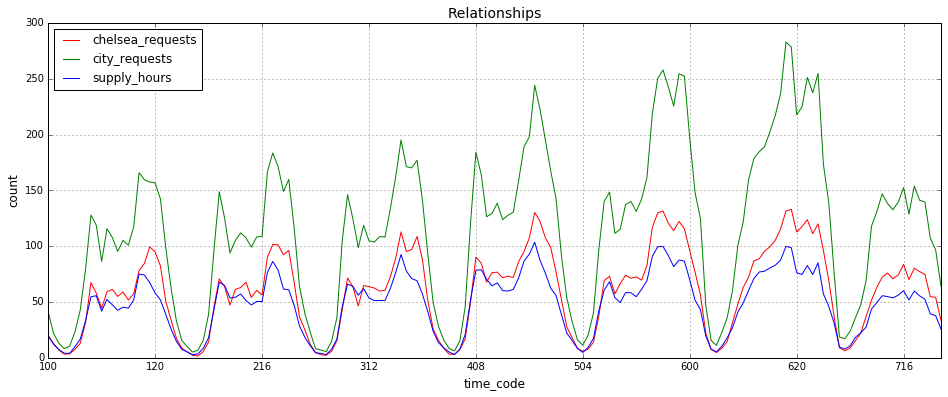

,supply_hours,chelsea_requests,chelsea_completion
supply_hours,1.000000,0.971206,0.254756
chelsea_requests,0.971206,1.000000,0.238987
chelsea_completion,0.254756,0.238987,1.000000


In [63]:
% matplotlib inline

ax1 = relationship_df.plot(x = 'code_stamp', y = 'chelsea_requests', figsize=(16,6), legend= True, color = 'r')

relationship_df.plot(ax=ax1, x = 'code_stamp', y = 'city_requests', legend= True, color = 'g')
relationship_df.plot(ax=ax1, x = 'code_stamp', y = 'supply_hours', legend= True, color = 'b')

ax1.grid(b=True, which ='major', linestyle='dotted', linewidth='0.5', color = 'k')
ax1.set_xlabel("time_code", fontsize = 12)
ax1.set_ylabel("count", fontsize = 12)
ax1.set_title("Relationships", fontsize = 14)

plt.show()

display(relationship_df[['supply_hours','chelsea_requests', 'chelsea_completion']].corr(method = 'pearson'))


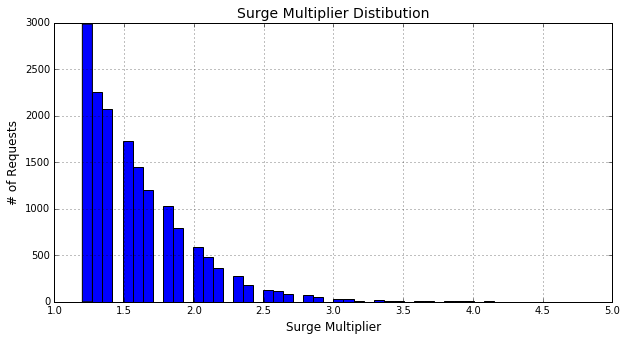

In [25]:
## Plot Surge Distibution

% matplotlib inline

ax1 = trips_df[trips_df['surge_multiplier'] >= 1.1]['surge_multiplier'].plot.hist(figsize=(10,5), bins = 50)

ax1.grid(b=True, which ='major', linestyle='dotted', linewidth='0.5', color = 'k')
ax1.set_xlabel("Surge Multiplier", fontsize = 12)
ax1.set_ylabel("# of Requests", fontsize = 12)
ax1.set_title("Surge Multiplier Distibution", fontsize = 14)
plt.show()

The distribution shows that > 2.5, the amount of trips with surge multipliers is too small a sample to draw any conclusive statistical significance from. Hence, in our correlation analysis, we will use 1.0 to 2.5 as our surge range

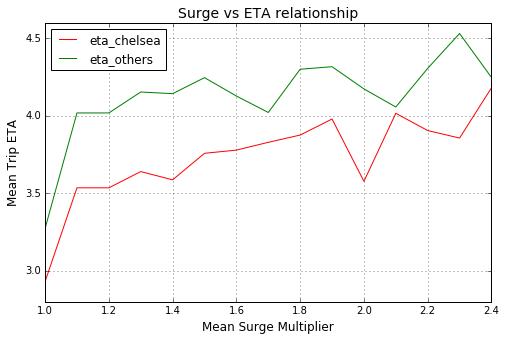

,surge_multiplier,eta_chelsea
surge_multiplier,1.000000,0.794901
eta_chelsea,0.794901,1.000000


,surge_multiplier,eta_others
surge_multiplier,1.000000,0.658463
eta_others,0.658463,1.000000


In [26]:
def make_surge_eta_chelsea(row):
    return trips_df[
        (trips_df['surge_multiplier'] >= row['surge_multiplier']) & 
        (trips_df['surge_multiplier'] < (row['surge_multiplier'] + 0.1)) & 
        (trips_df['start_geo'] == 'Chelsea Court')]['estimated_time_to_arrival'].mean()

def make_surge_eta_others(row):
    return trips_df[
        (trips_df['surge_multiplier'] >= row['surge_multiplier']) & 
        (trips_df['surge_multiplier'] < (row['surge_multiplier'] + 0.1)) & 
        (trips_df['start_geo'] != 'Chelsea Court')]['estimated_time_to_arrival'].mean()

surge_count_df = pd.DataFrame()
surge_count_df['surge_multiplier'] = pd.Series([x / 10 for x in list(
    range(int(10*trips_df['surge_multiplier'].min()) , int(10*trips_df['surge_multiplier'].max())))])

surge_count_df['eta_chelsea'] = surge_count_df.apply(make_surge_eta_chelsea, axis = 1)
surge_count_df['eta_others'] = surge_count_df.apply(make_surge_eta_others, axis = 1)

% matplotlib inline

ax1 = surge_count_df[surge_count_df['surge_multiplier'] <= 2.4].plot(
    x = 'surge_multiplier', y = 'eta_chelsea', figsize=(8,5), legend= True, color = 'r')
surge_count_df[surge_count_df['surge_multiplier'] <= 2.4].plot(
    ax=ax1, x = 'surge_multiplier', y = 'eta_others', legend= True, color = 'g')

ax1.grid(b=True, which ='major', linestyle='dotted', linewidth='0.5', color = 'k')
ax1.set_xlabel("Mean Surge Multiplier", fontsize = 12)
ax1.set_ylabel("Mean Trip ETA", fontsize = 12)
ax1.set_title("Surge vs ETA relationship", fontsize = 14)
start, end = ax1.get_xlim()
end += 0.1
ax1.xaxis.set_ticks(np.arange(start, end, 0.2))
plt.show()

display(surge_count_df[surge_count_df['surge_multiplier'] <= 2.4][[
            'surge_multiplier','eta_chelsea']].corr(method = 'pearson'))
surge_count_df[surge_count_df['surge_multiplier'] <= 2.4][[
        'surge_multiplier','eta_others']].corr(method = 'pearson')

The Pearson Coefficients in the correlation tables indicate a strong positive relationship between surge and ETA in both the rest of the city than for Chelsea Court, although from the charts, we can see that on average, trips with surge have at least 30 second longer wait times than trips without. 

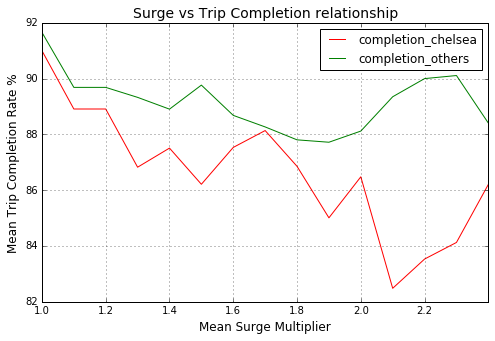

,surge_multiplier,completion_chelsea
surge_multiplier,1.000000,-0.807761
completion_chelsea,-0.807761,1.000000


,surge_multiplier,completion_others
surge_multiplier,1.000000,-0.393043
completion_others,-0.393043,1.000000


In [27]:
def make_surge_completion_chelsea(row):
    numerator = trips_df[
        (trips_df['surge_multiplier'] >= row['surge_multiplier']) & 
        (trips_df['surge_multiplier'] < (row['surge_multiplier'] + 0.1)) & 
        (trips_df['start_geo'] == 'Chelsea Court') & (trips_df['trip_status'] == 'completed')].shape[0]
    denominator = trips_df[(trips_df['surge_multiplier'] >= row['surge_multiplier']) & 
                           (trips_df['surge_multiplier'] < (row['surge_multiplier'] + 0.1)) &  
                           (trips_df['start_geo'] == 'Chelsea Court')].shape[0]
    if denominator == 0:
        return 0
    else:
        return 100 * (numerator / denominator)

def make_surge_completion_others(row):
    numerator = trips_df[
        (trips_df['surge_multiplier'] >= row['surge_multiplier']) & 
        (trips_df['surge_multiplier'] < (row['surge_multiplier'] + 0.1)) & 
        (trips_df['start_geo'] != 'Chelsea Court') & (trips_df['trip_status'] == 'completed')].shape[0]
    denominator = trips_df[(trips_df['surge_multiplier'] >= row['surge_multiplier']) & 
                           (trips_df['surge_multiplier'] < (row['surge_multiplier'] + 0.1)) & 
                           (trips_df['start_geo'] != 'Chelsea Court')].shape[0]
    if denominator == 0:
        return 0
    else:
        return 100 * (numerator / denominator)

surge_count_df['completion_chelsea'] = surge_count_df.apply(make_surge_completion_chelsea, axis = 1)
surge_count_df['completion_others'] = surge_count_df.apply(make_surge_completion_others, axis = 1)

% matplotlib inline

ax1 = surge_count_df[surge_count_df['surge_multiplier'] <= 2.4].plot(
    x = 'surge_multiplier', y = 'completion_chelsea', figsize=(8,5), legend= True, color = 'r')

surge_count_df[surge_count_df['surge_multiplier'] <= 2.4].plot(
    ax=ax1, x = 'surge_multiplier', y = 'completion_others', legend= True, color = 'g')

ax1.grid(b=True, which ='major', linestyle='dotted', linewidth='0.5', color = 'k')
ax1.set_xlabel("Mean Surge Multiplier", fontsize = 12)
ax1.set_ylabel("Mean Trip Completion Rate %", fontsize = 12)
ax1.set_title("Surge vs Trip Completion relationship", fontsize = 14)
start, end = ax1.get_xlim()
ax1.xaxis.set_ticks(np.arange(start, end, 0.2))
plt.show()

display(surge_count_df[surge_count_df['surge_multiplier'] <= 2.4][[
            'surge_multiplier','completion_chelsea']].corr(method = 'pearson'))
surge_count_df[surge_count_df['surge_multiplier'] <= 2.4][[
        'surge_multiplier','completion_others']].corr(method = 'pearson')

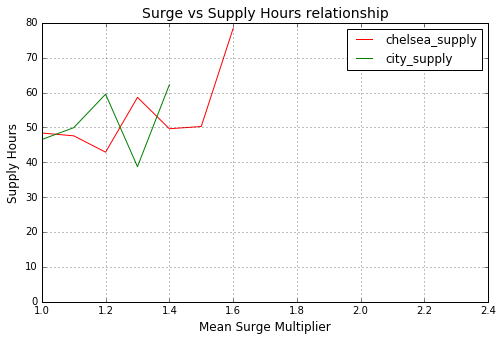

,supply_hours,city_surge
supply_hours,1.00000,0.03497
city_surge,0.03497,1.00000


,supply_hours,chelsea_surge
supply_hours,1.000000,-0.023406
chelsea_surge,-0.023406,1.000000


In [47]:
def make_chelsea_supply(row):
    return relationship_df[
        (relationship_df['chelsea_surge'] >= row['surge_multiplier']) & 
        (relationship_df['chelsea_surge'] < (row['surge_multiplier'] + 0.1))]['supply_hours'].mean()

def make_city_supply(row):
    return relationship_df[
        (relationship_df['city_surge'] >= row['surge_multiplier']) & 
        (relationship_df['city_surge'] < (row['surge_multiplier'] + 0.1))]['supply_hours'].mean()

surge_count_df['chelsea_supply'] = surge_count_df.apply(make_chelsea_supply, axis = 1)
surge_count_df['city_supply'] = surge_count_df.apply(make_city_supply, axis = 1)

% matplotlib inline

ax1 = surge_count_df[surge_count_df['surge_multiplier'] <= 2.4].plot(
    x = 'surge_multiplier', y = 'chelsea_supply', figsize=(8,5), legend= True, color = 'r')
surge_count_df[surge_count_df['surge_multiplier'] <= 2.4].plot(
    ax=ax1, x = 'surge_multiplier', y = 'city_supply', legend= True, color = 'g')

ax1.grid(b=True, which ='major', linestyle='dotted', linewidth='0.5', color = 'k')
ax1.set_xlabel("Mean Surge Multiplier", fontsize = 12)
ax1.set_ylabel("Supply Hours", fontsize = 12)
ax1.set_title("Surge vs Supply Hours relationship", fontsize = 14)
start, end = ax1.get_xlim()
end += 0.1
ax1.xaxis.set_ticks(np.arange(start, end, 0.2))
plt.show()

display (relationship_df[['supply_hours','city_surge']].corr(method = 'pearson'))
display (relationship_df[['supply_hours','chelsea_surge']].corr(method = 'pearson'))


The Pearson Coefficient shows that there is a strong negative correlation overall between surge and trip completion in Chelsea Court (a weaker correlation exists in the rest of the city), and the downward trend is clear to see in the chart

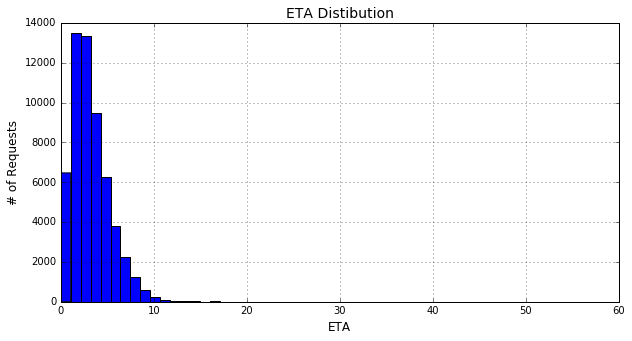

In [28]:
ETAs = pd.Series([x / 10 for x in list(
    range(int(10*trips_df['estimated_time_to_arrival'].min()) , 
          int(10*trips_df['estimated_time_to_arrival'].max())))])

ETA_count_df = pd.DataFrame()
ETA_count_df['ETA'] = ETAs

def make_ETA_count(row):
    return trips_df[
        (trips_df['estimated_time_to_arrival'] >= row['ETA']) & 
        (trips_df['estimated_time_to_arrival'] < row['ETA'] + 0.1)].shape[0]

ETA_count_df['count'] = ETA_count_df.apply(make_ETA_count, axis = 1)

ax1 = trips_df['estimated_time_to_arrival'].plot.hist(figsize=(10,5), bins = 50)

ax1.grid(b=True, which ='major', linestyle='dotted', linewidth='0.5', color = 'k')
ax1.set_xlabel("ETA", fontsize = 12)
ax1.set_ylabel("# of Requests", fontsize = 12)
ax1.set_title("ETA Distibution", fontsize = 14)
plt.show()


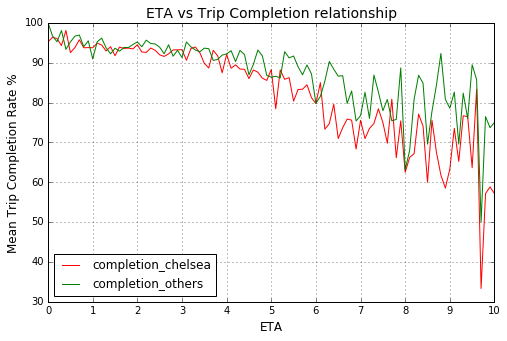

,ETA,completion_chelsea
ETA,1.000000,-0.916084
completion_chelsea,-0.916084,1.000000


,ETA,completion_others
ETA,1.000000,-0.805071
completion_others,-0.805071,1.000000


In [29]:
def make_eta_completion_chelsea(row):
    numerator = trips_df[
        (trips_df['estimated_time_to_arrival'] >= row['ETA']) & 
        (trips_df['estimated_time_to_arrival'] < (row['ETA'] + 0.1)) & 
        (trips_df['start_geo'] == 'Chelsea Court') & (trips_df['trip_status'] == 'completed')].shape[0]
    denominator = trips_df[(trips_df['estimated_time_to_arrival'] >= row['ETA']) & 
                           (trips_df['estimated_time_to_arrival'] < (row['ETA'] + 0.1)) &  
                           (trips_df['start_geo'] == 'Chelsea Court')].shape[0]
    if denominator == 0:
        return 0
    else:
        return 100 * (numerator / denominator)
    
def make_eta_completion_others(row):
    numerator = trips_df[
        (trips_df['estimated_time_to_arrival'] >= row['ETA']) & 
        (trips_df['estimated_time_to_arrival'] < (row['ETA'] + 0.1)) & 
        (trips_df['start_geo'] != 'Chelsea Court') & (trips_df['trip_status'] == 'completed')].shape[0]
    denominator = trips_df[(trips_df['estimated_time_to_arrival'] >= row['ETA']) & 
                           (trips_df['estimated_time_to_arrival'] < (row['ETA'] + 0.1)) &  
                           (trips_df['start_geo'] != 'Chelsea Court')].shape[0]
    if denominator == 0:
        return 0
    else:
        return 100 * (numerator / denominator)
    
ETA_count_df['completion_chelsea'] = ETA_count_df.apply(make_eta_completion_chelsea, axis = 1)
ETA_count_df['completion_others'] = ETA_count_df.apply(make_eta_completion_others, axis = 1)

% matplotlib inline

ax1 = ETA_count_df[ETA_count_df['ETA'] <= 10].plot(
    x = 'ETA', y = 'completion_chelsea', figsize=(8,5), legend= True, color = 'r')

ETA_count_df[ETA_count_df['ETA'] <= 10].plot(
    ax=ax1, x = 'ETA', y = 'completion_others', legend= True, color = 'g')

ax1.grid(b=True, which ='major', linestyle='dotted', linewidth='0.5', color = 'k')
ax1.set_xlabel("ETA", fontsize = 12)
ax1.set_ylabel("Mean Trip Completion Rate %", fontsize = 12)
ax1.set_title("ETA vs Trip Completion relationship", fontsize = 14)
start, end = ax1.get_xlim()
end += 1
ax1.xaxis.set_ticks(np.arange(start, end, 1))
plt.show()

display(ETA_count_df[ETA_count_df['ETA'] <= 9][[
            'ETA','completion_chelsea']].corr(method = 'pearson'))
ETA_count_df[ETA_count_df['ETA'] <= 9][[
        'ETA','completion_others']].corr(method = 'pearson')

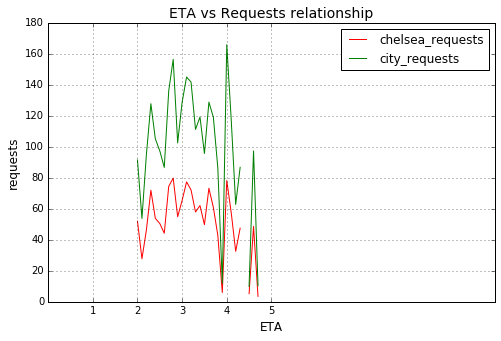

,chelsea_eta,chelsea_requests
chelsea_eta,1.000000,-0.166947
chelsea_requests,-0.166947,1.000000


,chelsea_eta,city_requests
chelsea_eta,1.000000,-0.159025
city_requests,-0.159025,1.000000


In [53]:
def make_eta_chelsea_req(row):
    return relationship_df[(relationship_df['chelsea_eta'] >= row['ETA']) & 
        (relationship_df['chelsea_eta'] < (row['ETA'] + 0.1))]['chelsea_requests'].mean() 

def make_eta_city_req(row):
    return relationship_df[(relationship_df['chelsea_eta'] >= row['ETA']) & 
        (relationship_df['chelsea_eta'] < (row['ETA'] + 0.1))]['city_requests'].mean() 
    
ETA_count_df['chelsea_requests'] = ETA_count_df.apply(make_eta_chelsea_req, axis = 1)
ETA_count_df['city_requests'] = ETA_count_df.apply(make_eta_city_req, axis = 1)

% matplotlib inline

ax1 = ETA_count_df[ETA_count_df['ETA'] <= 10].plot(
    x = 'ETA', y = 'chelsea_requests', figsize=(8,5), legend= True, color = 'r')

ETA_count_df[ETA_count_df['ETA'] <= 10].plot(
    ax=ax1, x = 'ETA', y = 'city_requests', legend= True, color = 'g')

ax1.grid(b=True, which ='major', linestyle='dotted', linewidth='0.5', color = 'k')
ax1.set_xlabel("ETA", fontsize = 12)
ax1.set_ylabel("requests", fontsize = 12)
ax1.set_title("ETA vs Requests relationship", fontsize = 14)
start, end = 1, 6
ax1.xaxis.set_ticks(np.arange(start, end, 1))
plt.show()

display(relationship_df[[
            'chelsea_eta','chelsea_requests']].corr(method = 'pearson'))
display(relationship_df[[
            'chelsea_eta','city_requests']].corr(method = 'pearson'))

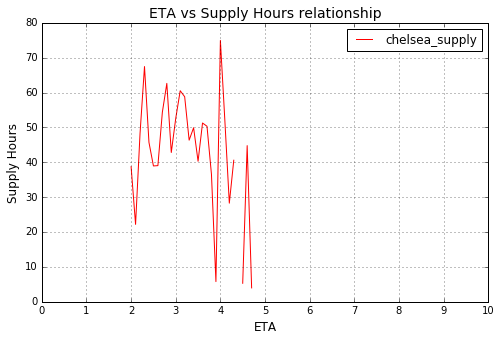

,chelsea_eta,supply_hours
chelsea_eta,1.000000,-0.162546
supply_hours,-0.162546,1.000000


,chelsea_eta,chelsea_completion
chelsea_eta,1.000000,-0.517701
chelsea_completion,-0.517701,1.000000


In [50]:
def make_eta_chelsea_supply(row):
    return relationship_df[(relationship_df['chelsea_eta'] >= row['ETA']) & 
        (relationship_df['chelsea_eta'] < (row['ETA'] + 0.1))]['supply_hours'].mean() 
    
ETA_count_df['chelsea_supply'] = ETA_count_df.apply(make_eta_chelsea_supply, axis = 1)

% matplotlib inline

ax1 = ETA_count_df[ETA_count_df['ETA'] <= 10].plot(
    x = 'ETA', y = 'chelsea_supply', figsize=(8,5), legend= True, color = 'r')

ax1.grid(b=True, which ='major', linestyle='dotted', linewidth='0.5', color = 'k')
ax1.set_xlabel("ETA", fontsize = 12)
ax1.set_ylabel("Supply Hours", fontsize = 12)
ax1.set_title("ETA vs Supply Hours relationship", fontsize = 14)
start, end = ax1.get_xlim()
end += 1
ax1.xaxis.set_ticks(np.arange(start, end, 1))
plt.show()

display(relationship_df[[
            'chelsea_eta','supply_hours']].corr(method = 'pearson'))
display(relationship_df[[
            'chelsea_eta','chelsea_completion']].corr(method = 'pearson'))

# Financial Sensitivity Analysis

In [33]:
financial_impact_df = trips_df[(~trips_df['day'].isin(['Saturday','Sunday'])) &
                               (trips_df['start_geo']=='Chelsea Court') & 
                               (trips_df['surge_multiplier'] >= surge_cutoff)]


In [34]:
display(financial_impact_df.shape[0])
display(financial_impact_df['trip_price_pre_discount'].sum())
display(financial_impact_df['rider_payment'].sum())
display(financial_impact_df['driver payout'].sum())
display(financial_impact_df['uber_revenue'].sum())
clear_output()

In [35]:
## Sensitivity Analysis


def sensitivity(discount,opt_in_ppt):
    opt_in_req_rate = promo_riders_segment.mean()
    non_req_rate = not_promo_riders_segment.mean()
    opt_in_conversion_rate = completion_rate(surge_trips_segment_df,1,'promotion_used')
    non_conversion_rate = completion_rate(surge_trips_segment_df,0,'promotion_used')
    loss_from_incomplete = financial_impact_df[financial_impact_df['trip_status']!='completed']['rider_payment'].mean()

    number_users_all = rider_data_df.shape[0]
    avg_pre_discount = financial_impact_df['trip_price_pre_discount'].sum()/financial_impact_df.shape[0]
    opt_requests = opt_in_ppt*number_users_all*opt_in_req_rate 
    non_requests = (1-opt_in_ppt)*non_req_rate*number_users_all
    avg_driver_payout = financial_impact_df['driver payout'].sum()/financial_impact_df.shape[0]

    requests = opt_requests + non_requests
    pre_discount = (avg_pre_discount)*(opt_requests + non_requests)
    calc_rider_payment = pre_discount - ((1-non_conversion_rate)*loss_from_incomplete) - ((
            1-opt_in_conversion_rate)*loss_from_incomplete) - (discount * opt_requests * avg_pre_discount)
    calc_driver_payout = avg_driver_payout * requests
    calc_uber_revenue = calc_rider_payment - calc_driver_payout
    
    output = [requests, pre_discount, calc_uber_revenue]

    return output

print(sensitivity(0.1,0.065))

[6597.81328435817, 52497.711519207754, 7802.915398812562]
